In [545]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [546]:
#Parameters
trading_window = 2

#MACD parameters
n = 9
m = 16
t = 6

#RSI parameters
period = 2

In [547]:
dataimport=pd.read_csv('/Users/hitengoel/Machine Learning/Pair Trading (ML:TI)/data/Sensex.csv')
datacopy1 = dataimport.copy()
dataimport['Date'] = pd.to_datetime(dataimport['Date'])
curr = dataimport.columns[0]
dataimport.rename(columns={curr: 'Stocks'}, inplace=True)
dataimport.set_index('Stocks', inplace=True)



In [548]:

def first_last_diff(x):
    return ((x.iloc[-1] - x.iloc[0])/x.iloc[0])
monthly = dataimport[dataimport.columns].resample('M').agg(first_last_diff)
#monthly.head()

In [549]:
data = dataimport.transpose()
#data.head()

In [550]:
train_data = monthly.iloc[:12]  

for i in train_data.columns:
    train_data[i] = (1 + train_data[i]).cumprod() - 1

train_data=train_data.transpose()
#train_data

/var/folders/94/qzww3__j7w95pdc_5q59f29c0000gn/T/ipykernel_15492/368789790.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[i] = (1 + train_data[i]).cumprod() - 1


In [551]:
from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation()
ap.fit(train_data)
labels = ap.predict(train_data)

In [552]:
groups = []
for i in range(labels.max()+1):
    arr = []
    for j in range(len(labels)):
        if labels[j] == i:
            arr.append(train_data.index[j])
    groups.append(arr)


for i in range(len(groups)):
    print("Group", i+1, ":", groups[i])

Group 1 : ['NTPC IB Equity', 'RELIANCE IB Equity', 'MM IB Equity', 'WPRO IB Equity', 'ICICIBC IB Equity']
Group 2 : ['KMB IB Equity', 'NEST IB Equity', 'BHARTI IB Equity', 'ITC IB Equity', 'UTCEM IB Equity', 'HUVR IB Equity', 'TTAN IB Equity']
Group 3 : ['TATA IB Equity', 'INFO IB Equity', 'MSIL IB Equity', 'SBIN IB Equity', 'TTMT IB Equity', 'JSTL IB Equity', 'LT IB Equity', 'AXSB IB Equity']
Group 4 : ['HCLT IB Equity', 'TCS IB Equity', 'SUNP IB Equity', 'BAF IB Equity', 'HDFCB IB Equity', 'APNT IB Equity', 'IIB IB Equity']


# Indicators

In [553]:

datacopy1['Date'] = pd.to_datetime(datacopy1['Date'])
datacopy1.set_index('Date', inplace=True)
data = datacopy1.resample('M').first()  # Weekly Resampling

data.reset_index(inplace=True)
data['Date'] = data['Date'].astype(str)
stock_names = data.columns[1:]

datacopy = data.copy()

#data

In [554]:
def MACD(price_data, short_window, long_window, signal_window, column_name):
    data = price_data
   
    data.loc[:,'EMAn'] = data[column_name].ewm(span=short_window, adjust=False).mean()
    data.loc[:,'EMAm'] = data[column_name].ewm(span=long_window, adjust=False).mean()

    for i in range(short_window):
        data.loc[i,'EMAn'] = None
    for i in range(long_window):
        data.loc[i,'EMAm'] = None
    
    data['MACD'] = data['EMAn'] - data['EMAm']
    data['Signal Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    trade_sig=np.zeros([len(data),1],dtype=float)

    for i in range(long_window+1,len(data)):
        if data.loc[i,'MACD'] > data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] < data.loc[i-1,'Signal Line']:
            trade_sig[i] = 1
        if data.loc[i,'MACD'] < data.loc[i,'Signal Line'] and data.loc[i-1,'MACD'] > data.loc[i-1,'Signal Line']:
            trade_sig[i] = -1
        
    trade_sig=trade_sig.reshape(len(trade_sig),1)

    data_numpy=data['Date'].to_numpy()
    data_numpy=data_numpy.reshape(len(data_numpy),1)
    data_numpy=np.column_stack((data_numpy,data[column_name].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAn'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['EMAm'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['MACD'].to_numpy()))
    data_numpy=np.column_stack((data_numpy,data['Signal Line'].to_numpy()))

    final=np.column_stack((data_numpy,trade_sig))
    final_df=pd.DataFrame(final,columns=['Date','Close','EMAn','EMAm','MACD','Signal Line','Trade Signal'],index=data.index)

    final_df.drop(["EMAn","EMAm","MACD","Signal Line"],axis=1,inplace=True)
    final_df['Date'] = pd.to_datetime(final_df['Date'])
    final_df['Close'] = final_df['Close'].astype(float) 
    final_df['Trade Signal'] = final_df['Trade Signal'].astype(int)

    return final_df


master_macd = pd.DataFrame()

for name in stock_names:
    temp = MACD(data, n, m, t, name)
    temp = temp[['Date','Trade Signal']]
    temp.columns = ['Date',name]
    temp.set_index('Date', inplace=True)
    master_macd = pd.concat([master_macd, temp], axis=1)

In [555]:
master_macd.insert(0, 'Date', master_macd.index)
master_macd.reset_index(drop=True, inplace=True)
master_macd = master_macd[period:]
master_macd = master_macd.reset_index(drop=True)
#master_macd = master_macd[232:725]
#master_macd

In [556]:
def calculate_rsi(prices, period):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def generate_signals(rsi_values):
    signals = np.zeros(rsi_values.shape)
    for rsi in rsi_values:
        if rsi < 30:
            signals[rsi_values == rsi] = 1
        elif rsi > 70:
            signals[rsi_values == rsi] = -1
    return signals

rsi_values = pd.DataFrame()
rsi_values['Date'] = data['Date']
for stock in stock_names:
    rsi_values[stock] = calculate_rsi(data[stock], period)

master_rsi = rsi_values[period:]

In [557]:
#master_rsi = master_rsi[232:725]
master_rsi = master_rsi.reset_index(drop=True)
#master_rsi

In [558]:
prices = datacopy
prices = prices[period:]
prices = prices.reset_index(drop=True)
#prices

#  strat1 RSI+MACD fixed exit strat

In [559]:
def get_returns1(groups,master_macd,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    tradesheet = pd.DataFrame(columns=['Date','Buy Stock','Sell Stock','Buy Price','Sell Price','Buy Quantity','Sell Quantity','Profit'])
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_macd.iloc[i,j]==1):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_macd.iloc[i,j]==-1):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[buy],'Sell Stock':prices.columns[sell],'Buy Price':prices.iloc[i,buy],'Sell Price':prices.iloc[i,sell],'Buy Quantity':buy_quantity,'Sell Quantity':float(1),'Profit':0},index=[0])
                tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                intrade.append(l)
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                r = (((b2-b1))*intrade[x][2]) + ((s1-s2))
                temp += r
                row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[intrade[x][3]],'Sell Stock':prices.columns[intrade[x][1]],'Buy Price':s2,'Sell Price':b2,'Buy Quantity':float(1),'Sell Quantity':intrade[x][2],'Profit':r},index=[0])
                tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                n += 1
            intrade = []
            returns.append(temp)
            num_trades.append(n)
            n = 0
            temp = 0

        i += 1

    return returns,num_trades, tradesheet

In [560]:
returns,num_trades, tradesheet1 = get_returns1(groups,master_macd,master_rsi,prices,trading_window)

/var/folders/94/qzww3__j7w95pdc_5q59f29c0000gn/T/ipykernel_15492/3216794123.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tradesheet = pd.concat([tradesheet,row],ignore_index=True)


In [561]:

windows = []
for i in range(len(returns)):
    windows.append(i+1)

tradesheet1.to_csv('/Users/hitengoel/Machine Learning/Pair Trading (ML:TI)/tradesheets/Sensex/With Clustering/Monthly MACD+RSI Fixed Sensex.csv',index=False)
tradesheet1

,Date,Buy Stock,Sell Stock,Buy Price,Sell Price,Buy Quantity,Sell Quantity,Profit
0,2012-08-31,MM IB Equity,WPRO IB Equity,349.13,113.60,0.325380,1.000000,0
1,2012-08-31,WPRO IB Equity,MM IB Equity,113.60,349.13,1.000000,0.325380,0.0
2,2013-06-30,NTPC IB Equity,WPRO IB Equity,126.88,122.12,0.962484,1.000000,0
3,2013-06-30,WPRO IB Equity,NTPC IB Equity,122.12,126.88,1.000000,0.962484,0.0
4,2013-07-31,WPRO IB Equity,NTPC IB Equity,131.70,123.08,0.934548,1.000000,0
5,2013-08-31,NTPC IB Equity,WPRO IB Equity,109.25,163.58,1.000000,0.934548,43.623397
6,2013-12-31,KMB IB Equity,HUVR IB Equity,384.85,583.25,1.515526,1.000000,0
7,2013-12-31,HUVR IB Equity,KMB IB Equity,583.25,384.85,1.000000,1.515526,0.0
8,2014-01-31,BAF IB Equity,APNT IB Equity,157.54,499.85,3.172845,1.000000,0
9,2014-02-28,APNT IB Equity,BAF IB Equity,471.15,149.73,1.000000,3.172845,3.920081


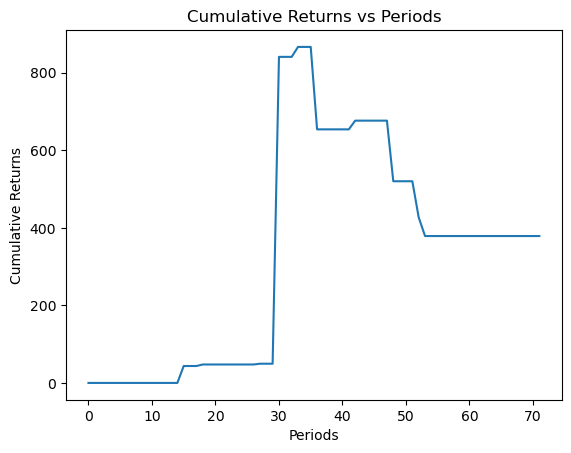

In [562]:
cumulative_returns_1 = []
cumulative_returns_1.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_1.append(s)


plt.plot(windows,cumulative_returns_1)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()


# Strat-2 with variable exit in window + fixed exit at the end

In [563]:
def get_returns2(groups,master_macd,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    tradesheet = pd.DataFrame(columns=['Date','Buy Stock','Sell Stock','Buy Price','Sell Price','Buy Quantity','Sell Quantity','Profit'])
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_macd.iloc[i,j]==1):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_macd.iloc[i,j]==-1):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[buy],'Sell Stock':prices.columns[sell],'Buy Price':prices.iloc[i,buy],'Sell Price':prices.iloc[i,sell],'Buy Quantity':buy_quantity,'Sell Quantity':float(1),'Profit':0},index=[0])
                tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                intrade.append(l)
            
            elif(buy!=0):
                for trade in intrade:
                    if(trade[3]==buy):
                        b1 = prices.iloc[trade[0],trade[1]]
                        s1 = prices.iloc[trade[0],trade[3]]
                        b2 = prices.iloc[i,trade[1]]
                        s2 = prices.iloc[i,trade[3]]
                        r = (((b2-b1))*trade[2]) + ((s1-s2))
                        temp += r
                        row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[trade[3]],'Sell Stock':prices.columns[trade[1]],'Buy Price':s2,'Sell Price':b2,'Buy Quantity':float(1),'Sell Quantity':trade[2],'Profit':r},index=[0])
                        tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                        intrade.remove(trade)
                        n += 1


            elif(sell!=0):
                for trade in intrade:
                    if(trade[1]==sell):
                        b1 = prices.iloc[trade[0],trade[1]]
                        s1 = prices.iloc[trade[0],trade[3]]
                        b2 = prices.iloc[i,trade[1]]
                        s2 = prices.iloc[i,trade[3]]
                        r = (((b2-b1))*trade[2]) + ((s1-s2))
                        temp += r
                        row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[trade[3]],'Sell Stock':prices.columns[trade[1]],'Buy Price':s2,'Sell Price':b2,'Buy Quantity':float(1),'Sell Quantity':trade[2],'Profit':r},index=[0])
                        tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                        intrade.remove(trade)
                        n += 1 
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                r = (((b2-b1))*intrade[x][2]) + ((s1-s2))
                temp += r
                row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[intrade[x][3]],'Sell Stock':prices.columns[intrade[x][1]],'Buy Price':s2,'Sell Price':b2,'Buy Quantity':float(1),'Sell Quantity':intrade[x][2],'Profit':r},index=[0])
                tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                n += 1
            intrade = []
            returns.append(temp)
            num_trades.append(n)
            temp = 0
            n = 0

        i += 1

    return returns,num_trades, tradesheet

In [564]:
returns,num_trades, tradesheet2 = get_returns2(groups,master_macd,master_rsi,prices,trading_window)

/var/folders/94/qzww3__j7w95pdc_5q59f29c0000gn/T/ipykernel_15492/3871633366.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tradesheet = pd.concat([tradesheet,row],ignore_index=True)


In [565]:

windows = []
for i in range(len(returns)):
    windows.append(i+1)

tradesheet2.to_csv('/Users/hitengoel/Machine Learning/Pair Trading (ML:TI)/tradesheets/Sensex/With Clustering/Monthly MACD+RSI Variable Sensex.csv',index=False)
tradesheet2

,Date,Buy Stock,Sell Stock,Buy Price,Sell Price,Buy Quantity,Sell Quantity,Profit
0,2012-08-31,MM IB Equity,WPRO IB Equity,349.13,113.60,0.325380,1.000000,0
1,2012-08-31,WPRO IB Equity,MM IB Equity,113.60,349.13,1.000000,0.325380,0.0
2,2013-06-30,NTPC IB Equity,WPRO IB Equity,126.88,122.12,0.962484,1.000000,0
3,2013-06-30,WPRO IB Equity,NTPC IB Equity,122.12,126.88,1.000000,0.962484,0.0
4,2013-07-31,WPRO IB Equity,NTPC IB Equity,131.70,123.08,0.934548,1.000000,0
5,2013-08-31,NTPC IB Equity,WPRO IB Equity,109.25,163.58,1.000000,0.934548,43.623397
6,2013-12-31,KMB IB Equity,HUVR IB Equity,384.85,583.25,1.515526,1.000000,0
7,2013-12-31,HUVR IB Equity,KMB IB Equity,583.25,384.85,1.000000,1.515526,0.0
8,2014-01-31,BAF IB Equity,APNT IB Equity,157.54,499.85,3.172845,1.000000,0
9,2014-02-28,APNT IB Equity,BAF IB Equity,471.15,149.73,1.000000,3.172845,3.920081


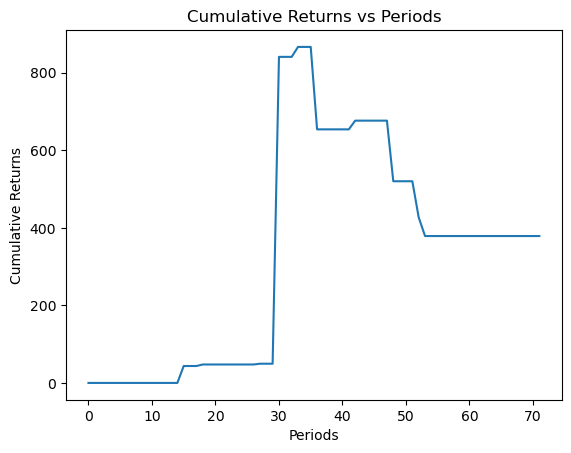

In [566]:

cumulative_returns_2 = []
cumulative_returns_2.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_2.append(s)


plt.plot(windows,cumulative_returns_2)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()


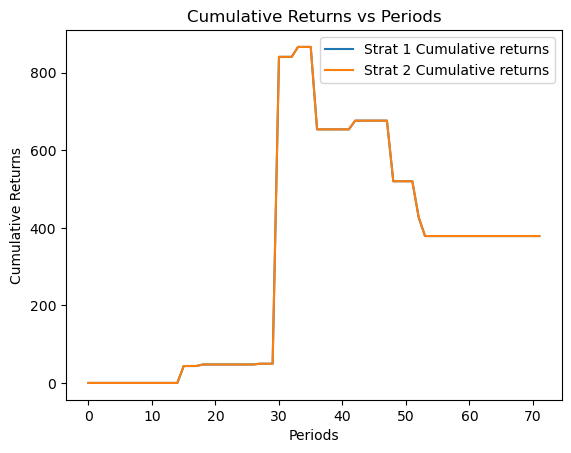

In [567]:
plt.plot(windows,cumulative_returns_1,label = "Strat 1 Cumulative returns")
plt.plot(windows,cumulative_returns_2,label = "Strat 2 Cumulative returns")
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.legend()
plt.savefig('/Users/hitengoel/Machine Learning/Pair Trading (ML:TI)/Plots/Sensex With Clustering Monthly MACD+RSI.png')
plt.show()

# strat 3 RSI Fixed exit

In [568]:
def get_returns3(groups,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    tradesheet = pd.DataFrame(columns=['Date','Buy Stock','Sell Stock','Buy Price','Sell Price','Buy Quantity','Sell Quantity','Profit'])
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_rsi.iloc[i,j]<30):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_rsi.iloc[i,j]>70):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[buy],'Sell Stock':prices.columns[sell],'Buy Price':prices.iloc[i,buy],'Sell Price':prices.iloc[i,sell],'Buy Quantity':buy_quantity,'Sell Quantity':float(1),'Profit':0},index=[0])
                tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                intrade.append(l)
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                r = (((b2-b1))*intrade[x][2]) + ((s1-s2))
                temp += r
                row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[intrade[x][3]],'Sell Stock':prices.columns[intrade[x][1]],'Buy Price':s2,'Sell Price':b2,'Buy Quantity':float(1),'Sell Quantity':intrade[x][2],'Profit':r},index=[0])
                tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                n+=1
            intrade = []
            returns.append(temp)
            temp = 0
            num_trades.append(n)
            n = 0

        i += 1

    return returns,num_trades, tradesheet

In [569]:
returns,num_trades, tradesheet3 = get_returns3(groups,master_rsi,prices,trading_window)

/var/folders/94/qzww3__j7w95pdc_5q59f29c0000gn/T/ipykernel_15492/2614391882.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tradesheet = pd.concat([tradesheet,row],ignore_index=True)


In [570]:

windows = []
for i in range(len(returns)):
    windows.append(i+1)

tradesheet3.to_csv('/Users/hitengoel/Machine Learning/Pair Trading (ML:TI)/tradesheets/Sensex/With Clustering/Monthly RSI Fixed Sensex.csv',index=False)
tradesheet3

,Date,Buy Stock,Sell Stock,Buy Price,Sell Price,Buy Quantity,Sell Quantity,Profit
0,2011-04-30,TATA IB Equity,AXSB IB Equity,58.69,281.81,4.801670,1.000000,0
1,2011-04-30,APNT IB Equity,TCS IB Equity,251.84,589.83,2.342082,1.000000,0
2,2011-04-30,AXSB IB Equity,TATA IB Equity,281.81,58.69,1.000000,4.801670,0.0
3,2011-04-30,TCS IB Equity,APNT IB Equity,589.83,251.84,1.000000,2.342082,0.0
4,2011-05-31,NTPC IB Equity,MM IB Equity,151.17,370.48,2.450751,1.000000,0
...,...,...,...,...,...,...,...,...
587,2022-10-31,IIB IB Equity,TCS IB Equity,1156.10,2985.70,1.000000,0.387212,0.0
588,2022-11-30,WPRO IB Equity,NTPC IB Equity,392.45,181.75,0.463116,1.000000,0
589,2022-12-31,BAF IB Equity,HCLT IB Equity,6747.00,1136.05,0.168379,1.000000,0
590,2022-12-31,NTPC IB Equity,WPRO IB Equity,172.20,413.60,1.000000,0.463116,19.34491


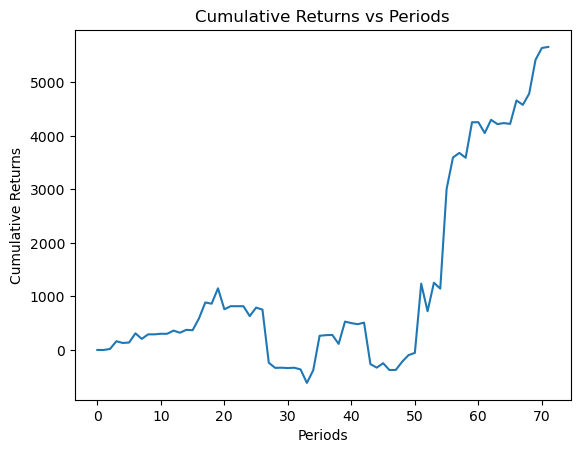

In [571]:
cumulative_returns_3 = []
cumulative_returns_3.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_3.append(s)


plt.plot(windows,cumulative_returns_3)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()

# strat 4 RSI variable exit

In [572]:
def get_returns4(groups,master_rsi,prices,period) :
    returns = []
    num_trades = []
    temp = 0
    intrade = []
    tradesheet = pd.DataFrame(columns=['Date','Buy Stock','Sell Stock','Buy Price','Sell Price','Buy Quantity','Sell Quantity','Profit'])
    i = 0
    n = 0
    while i<len(prices):
        for group in groups:
            buy = 0
            buy_rsi = 100.0
            sell = 0
            sell_rsi = 0.0
            for j in range(1,len(prices.columns)):
                if(prices.columns[j] in group):
                    if(master_rsi.iloc[i,j]<30):
                        if(master_rsi.iloc[i,j]<buy_rsi):
                            buy = j
                            buy_rsi = master_rsi.iloc[i,j]
                    elif(master_rsi.iloc[i,j]>70):
                        if(master_rsi.iloc[i,j]>sell_rsi):
                            sell = j
                            sell_rsi = master_rsi.iloc[i,j]
            
            if(buy!=0 and sell!=0):
                buy_quantity = float(prices.iloc[i,sell]/prices.iloc[i,buy])
                l = [i,buy,buy_quantity,sell]
                row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[buy],'Sell Stock':prices.columns[sell],'Buy Price':prices.iloc[i,buy],'Sell Price':prices.iloc[i,sell],'Buy Quantity':buy_quantity,'Sell Quantity':float(1),'Profit':0},index=[0])
                tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                intrade.append(l)

            elif(buy!=0):
                for trade in intrade:
                    if(trade[3]==buy):
                        b1 = prices.iloc[trade[0],trade[1]]
                        s1 = prices.iloc[trade[0],trade[3]]
                        b2 = prices.iloc[i,trade[1]]
                        s2 = prices.iloc[i,trade[3]]
                        r = (((b2-b1))*trade[2]) + ((s1-s2))
                        temp += r
                        row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[trade[3]],'Sell Stock':prices.columns[trade[1]],'Buy Price':s2,'Sell Price':b2,'Buy Quantity':float(1),'Sell Quantity':trade[2],'Profit':r},index=[0])
                        tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                        intrade.remove(trade)
                        n += 1


            elif(sell!=0):
                for trade in intrade:
                    if(trade[1]==sell):
                        b1 = prices.iloc[trade[0],trade[1]]
                        s1 = prices.iloc[trade[0],trade[3]]
                        b2 = prices.iloc[i,trade[1]]
                        s2 = prices.iloc[i,trade[3]]
                        r = (((b2-b1))*trade[2]) + ((s1-s2))
                        temp += r
                        row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[trade[3]],'Sell Stock':prices.columns[trade[1]],'Buy Price':s2,'Sell Price':b2,'Buy Quantity':float(1),'Sell Quantity':trade[2],'Profit':r},index=[0])
                        tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                        intrade.remove(trade)
                        n += 1
        
        if((i+1)%period==0):
            for x in range(len(intrade)):
                b1 = prices.iloc[intrade[x][0],intrade[x][1]]
                s1 = prices.iloc[intrade[x][0],intrade[x][3]]
                b2 = prices.iloc[i,intrade[x][1]]
                s2 = prices.iloc[i,intrade[x][3]]
                r = (((b2-b1))*intrade[x][2]) + ((s1-s2))
                temp += r
                row = pd.DataFrame({'Date':prices.iloc[i,0],'Buy Stock':prices.columns[intrade[x][3]],'Sell Stock':prices.columns[intrade[x][1]],'Buy Price':s2,'Sell Price':b2,'Buy Quantity':float(1),'Sell Quantity':intrade[x][2],'Profit':r},index=[0])
                tradesheet = pd.concat([tradesheet,row],ignore_index=True)
                n+=1
            intrade = []
            returns.append(temp)
            temp = 0
            num_trades.append(n)
            n = 0

        i += 1

    return returns,num_trades, tradesheet

In [573]:
returns,num_trades, tradesheet4 = get_returns4(groups,master_rsi,prices,trading_window)

/var/folders/94/qzww3__j7w95pdc_5q59f29c0000gn/T/ipykernel_15492/547718037.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tradesheet = pd.concat([tradesheet,row],ignore_index=True)


In [574]:

windows = []
for i in range(len(returns)):
    windows.append(i+1)

tradesheet4.to_csv('/Users/hitengoel/Machine Learning/Pair Trading (ML:TI)/tradesheets/Sensex/With Clustering/Monthly RSI Variable Sensex.csv',index=False)
tradesheet4

,Date,Buy Stock,Sell Stock,Buy Price,Sell Price,Buy Quantity,Sell Quantity,Profit
0,2011-04-30,TATA IB Equity,AXSB IB Equity,58.69,281.81,4.801670,1.000000,0
1,2011-04-30,APNT IB Equity,TCS IB Equity,251.84,589.83,2.342082,1.000000,0
2,2011-04-30,AXSB IB Equity,TATA IB Equity,281.81,58.69,1.000000,4.801670,0.0
3,2011-04-30,TCS IB Equity,APNT IB Equity,589.83,251.84,1.000000,2.342082,0.0
4,2011-05-31,NTPC IB Equity,MM IB Equity,151.17,370.48,2.450751,1.000000,0
...,...,...,...,...,...,...,...,...
587,2022-10-31,IIB IB Equity,TCS IB Equity,1156.10,2985.70,1.000000,0.387212,0.0
588,2022-11-30,WPRO IB Equity,NTPC IB Equity,392.45,181.75,0.463116,1.000000,0
589,2022-12-31,BAF IB Equity,HCLT IB Equity,6747.00,1136.05,0.168379,1.000000,0
590,2022-12-31,NTPC IB Equity,WPRO IB Equity,172.20,413.60,1.000000,0.463116,19.34491


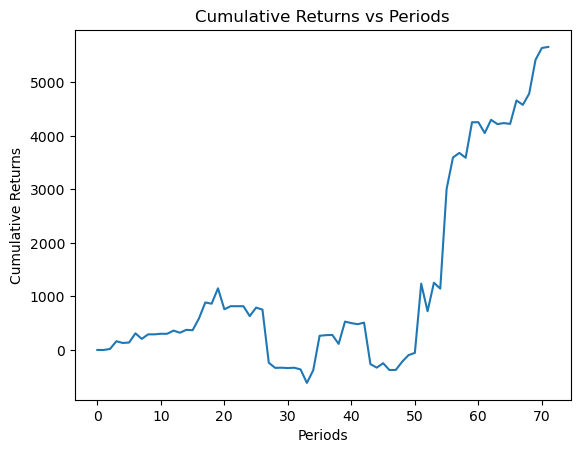

In [575]:
cumulative_returns_4 = []
cumulative_returns_4.insert(0,0)
windows.insert(0,0)
s = 0
for i in returns :
    s = s + i
    cumulative_returns_4.append(s)


plt.plot(windows,cumulative_returns_4)
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.show()

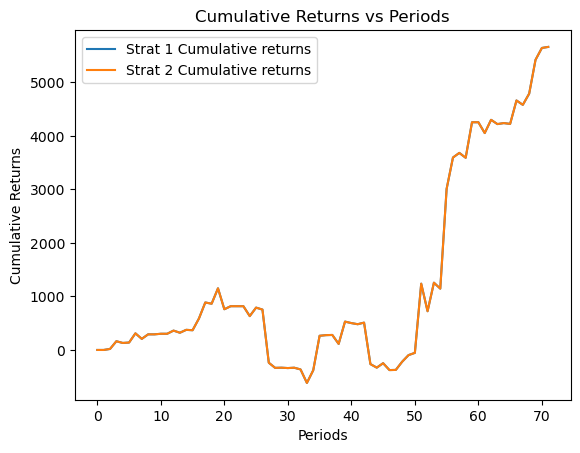

In [576]:
plt.plot(windows,cumulative_returns_3,label = "Strat 1 Cumulative returns")
plt.plot(windows,cumulative_returns_4,label = "Strat 2 Cumulative returns")
plt.xlabel('Periods')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns vs Periods')
plt.legend()
plt.savefig('/Users/hitengoel/Machine Learning/Pair Trading (ML:TI)/Plots/Sensex With Clustering Monthly RSI.png')
plt.show()
